In [2]:
%run Imports.ipynb
%run DataFrameBuilder.ipynb
%run ModelBuilder.ipynb
%run ModelEvaluator.ipynb
from tqdm.notebook import tqdm

# Own Train set

In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [4]:
def TrainTestSplit(df, ratio):
    train_size = int(len(df)*ratio)
    test_size = len(df)-train_size
    train_set = df.iloc[: train_size]
    test_set = df.iloc[-test_size:]

    return train_set, test_set

def input_data(seq, ws):
    out = []
    L = len(seq)
    
    for i in range(L-ws):
        window = seq.iloc[i:i+window_size]
        window_values = torch.cuda.FloatTensor(window.values)
        label = seq.target.iloc[i+ws:i+ws+1]
        label_value = torch.cuda.FloatTensor(label.values)
        out.append((window_values, label_value))
        
    return out

In [5]:
df = LoadDifferencedDatasetWithTarget(replace_old=True, target = 'value')
cols = df.columns

#df = pd.DataFrame(df.target, columns=['target'])
#df.target = df.target/100

In [6]:
window_size = 50

#50% definitions of tanh
scaler = MinMaxScaler(feature_range=(-0.5, 0.5))

train_df, test_df = TrainTestSplit(df, 0.8)

train_df_index = train_df.index
test_df_index = test_df.index

scaler = scaler.fit(train_df)

train_df = pd.DataFrame(scaler.transform(train_df), columns=cols, index=train_df_index)
test_df = pd.DataFrame(scaler.transform(test_df), columns=cols, index=test_df_index)

train_data = input_data(train_df, window_size)

In [7]:
train_df.shape

(5680, 27)

In [8]:
test_df.shape

(1421, 27)

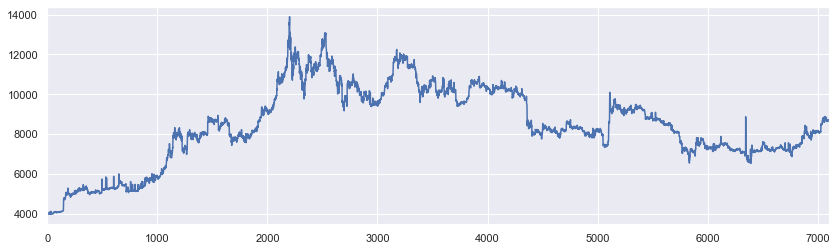

In [9]:
plt.figure(figsize =(14,4))
plt.xlim(0, df.shape[0])
plt.grid(True)
plt.plot(df.target)


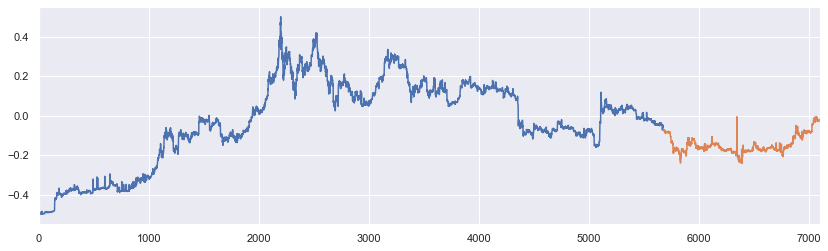

In [10]:
plt.figure(figsize =(14,4))
plt.xlim(0, train_df.shape[0]+test_df.shape[0])
plt.grid(True)
plt.plot(train_df.target)
plt.plot(test_df.target)

In [29]:
class MLSTM(nn.Module):
    def __init__(self, input_size = train_df.shape[1], hidden_size = 50, out_size = 1):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, out_size)
        
        self.hidden = (torch.zeros(1,1, hidden_size), torch.zeros(1,1, hidden_size))#tu sa musi nieco zmenit #dotrenovanie
        
    def forward(self, seq):
        #import pdb; pdb.set_trace()
        lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1,-1))
        #lstm_oud, (hid, cell) = self.lstm(
        # pred[-1] = self.linear(hid)
        pred = self.linear(lstm_out.view(len(seq), -1))
        #import pdb; pdb.set_trace()
        return pred[-1]

In [30]:
train_data[0][0].view(len(train_data[0][0]), 1,-1).shape

torch.Size([50, 1, 27])

In [31]:
torch.manual_seed(42)
model = MLSTM()
model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.005 )


Epoch 0 Loss: 0.003526665882647071
Performance on test range: 0.011985098011791706


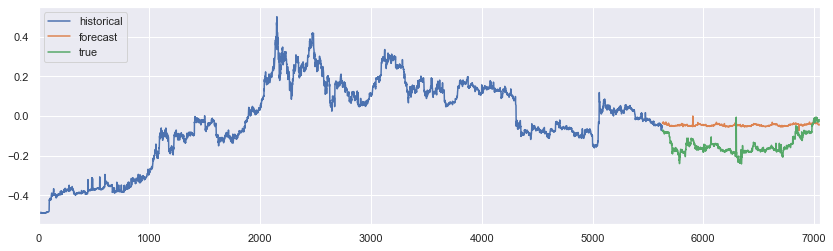

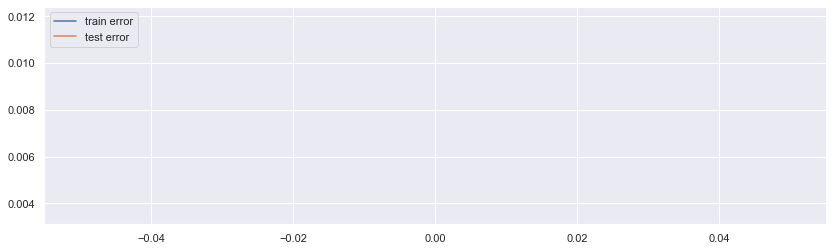


Epoch 1 Loss: 0.0023510118748681784
Performance on test range: 0.011264756321907043


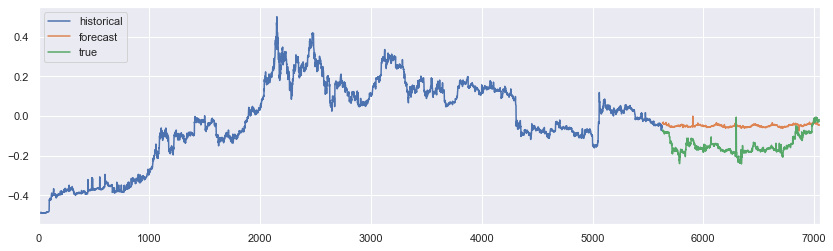

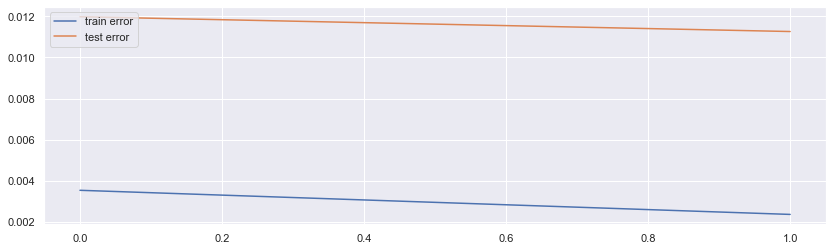


Epoch 2 Loss: 0.002199087853572759
Performance on test range: 0.01060263067483902


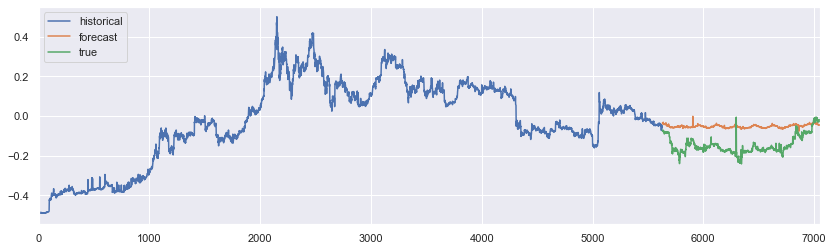

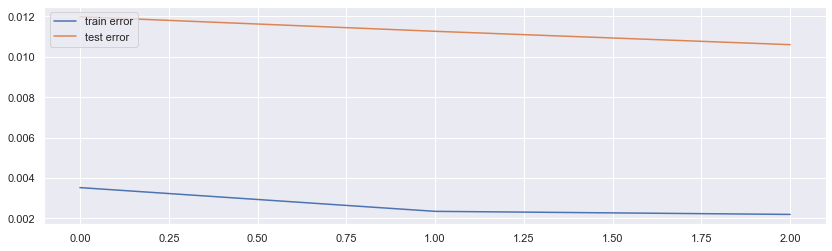


Epoch 3 Loss: 0.0020443831590931326
Performance on test range: 0.009936153888702393


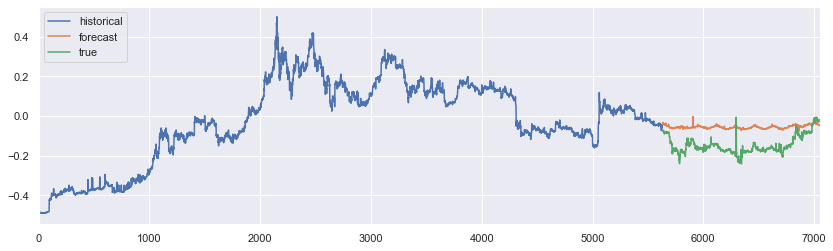

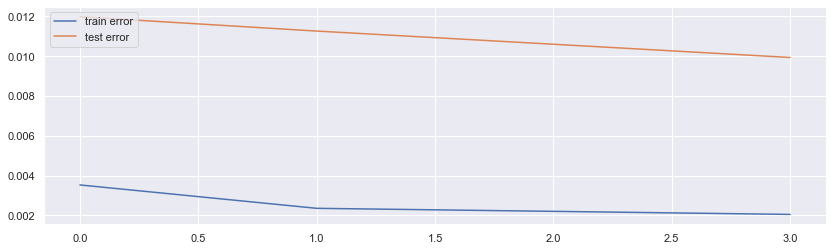


Epoch 4 Loss: 0.0018870070658862322
Performance on test range: 0.009255079552531242


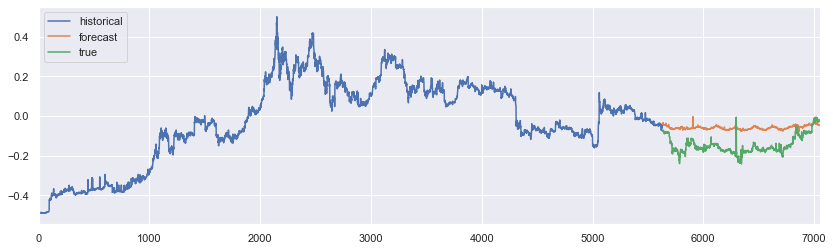

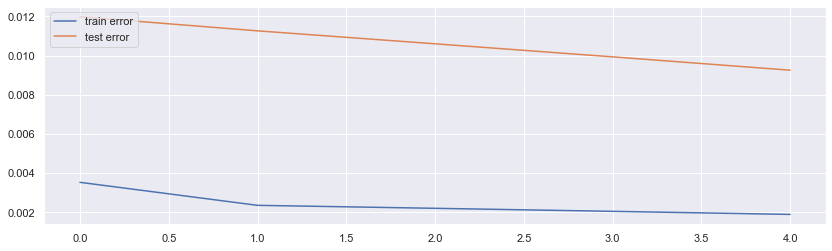


Epoch 5 Loss: 0.0017285873034127441
Performance on test range: 0.008562520146369934


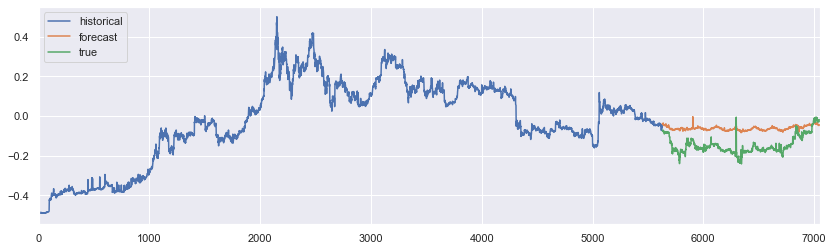

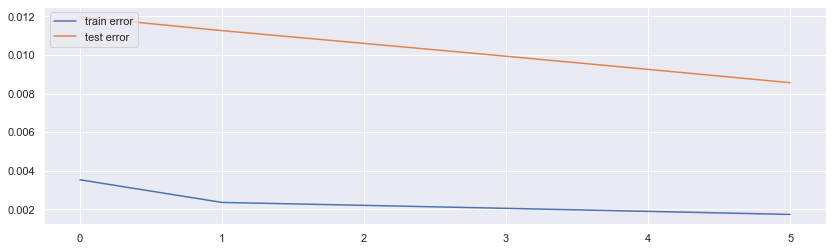


Epoch 6 Loss: 0.0015712761703998931
Performance on test range: 0.00786507222801447


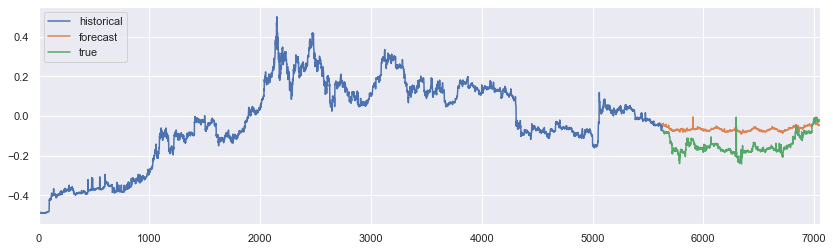

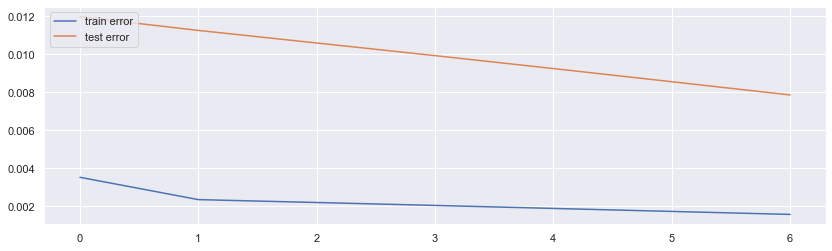


Epoch 7 Loss: 0.0014174020114313076
Performance on test range: 0.0071706571616232395


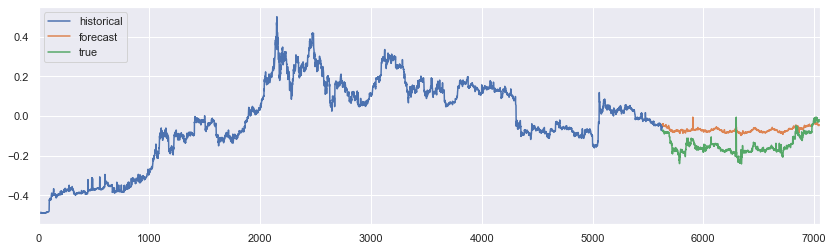

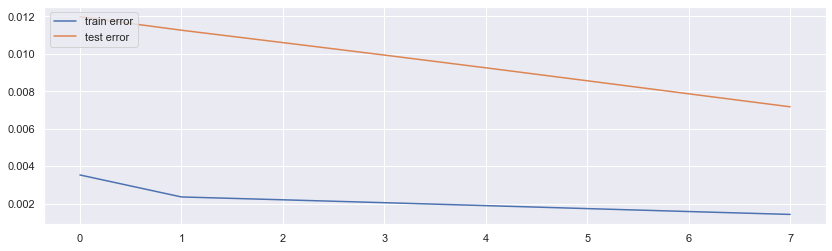


Epoch 8 Loss: 0.0012692516818317648
Performance on test range: 0.00648788595572114


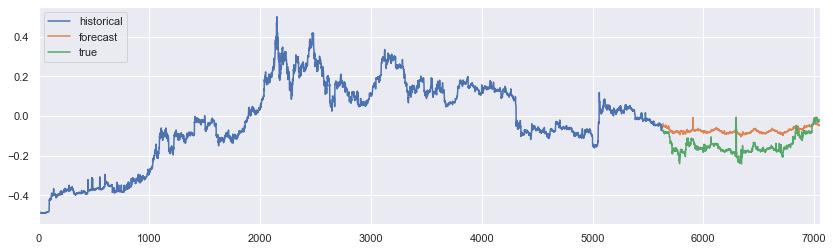

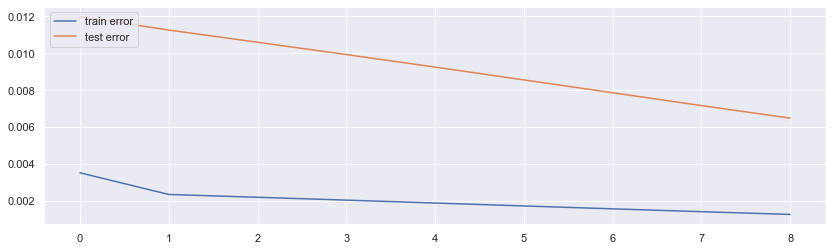


Epoch 9 Loss: 0.0011288992512664177
Performance on test range: 0.00582551397383213


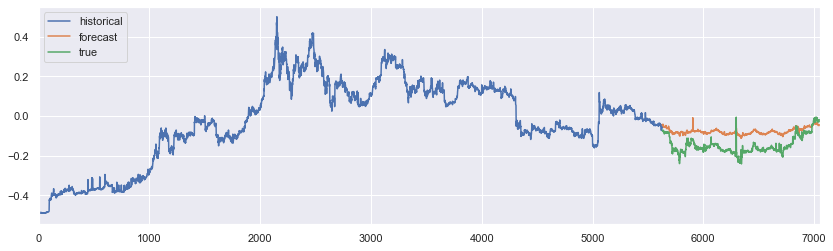

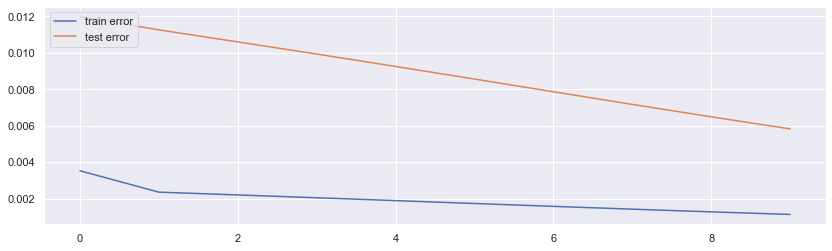


Epoch 10 Loss: 0.0009980600799934982
Performance on test range: 0.00519179180264473


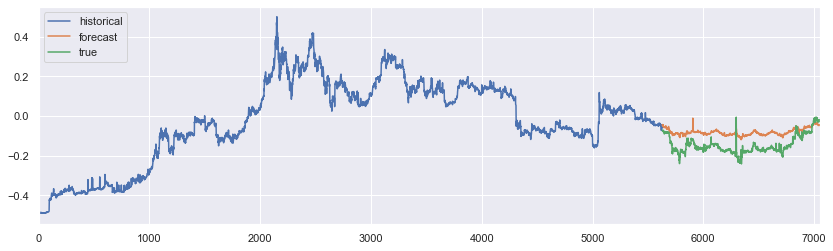

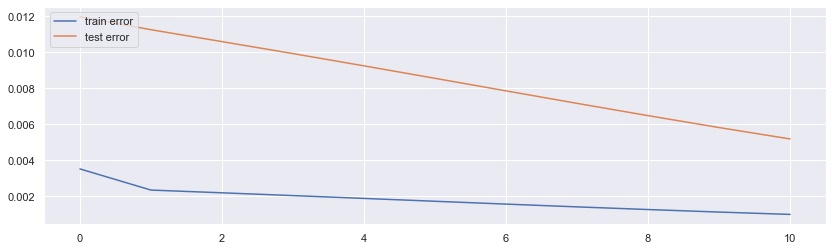


Epoch 11 Loss: 0.0008779985420414852
Performance on test range: 0.004593932535499334


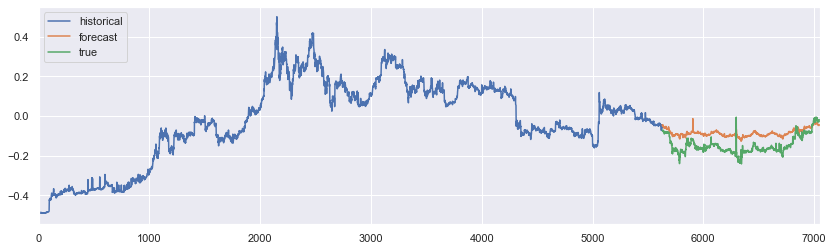

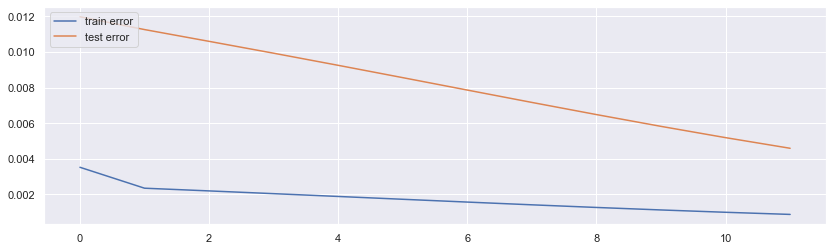


Epoch 12 Loss: 0.0007694792469944266
Performance on test range: 0.004037661477923393


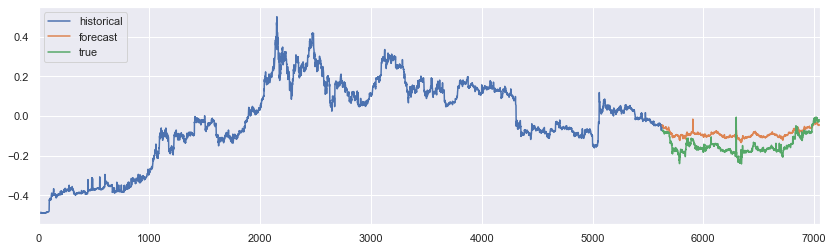

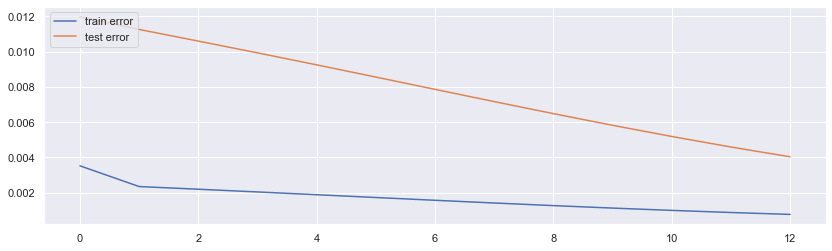


Epoch 13 Loss: 0.000672782722318661
Performance on test range: 0.0035270003136247396


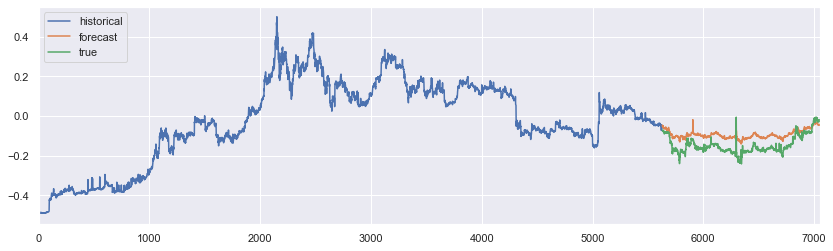

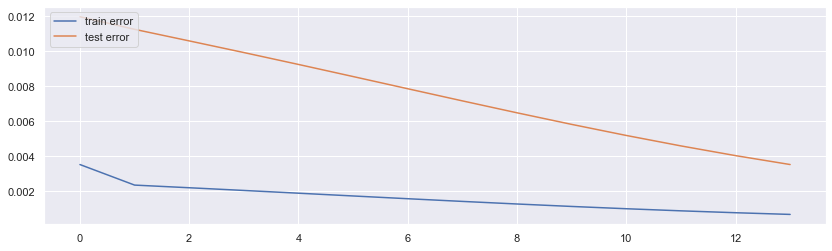


Epoch 14 Loss: 0.0005877528649783771
Performance on test range: 0.003064192598685622


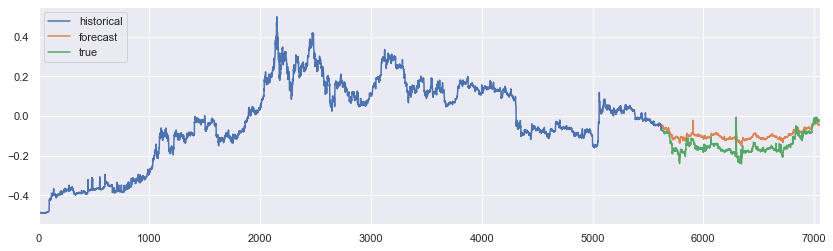

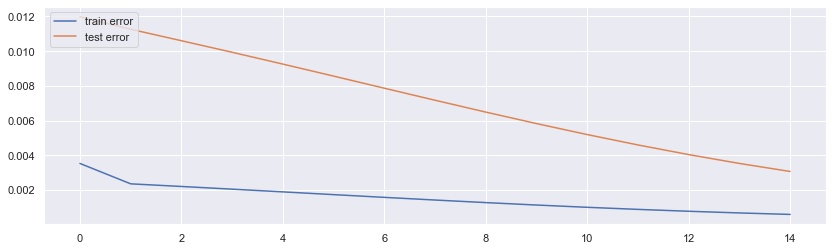


Epoch 15 Loss: 0.0005138858418723291
Performance on test range: 0.002649796660989523


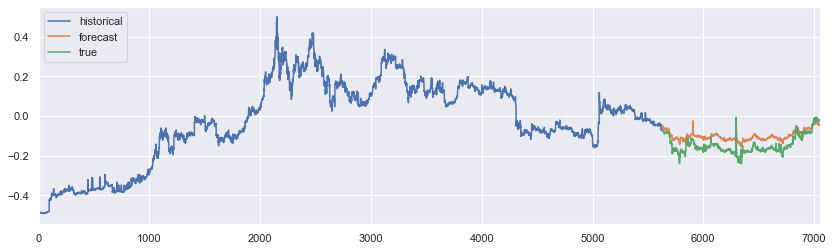

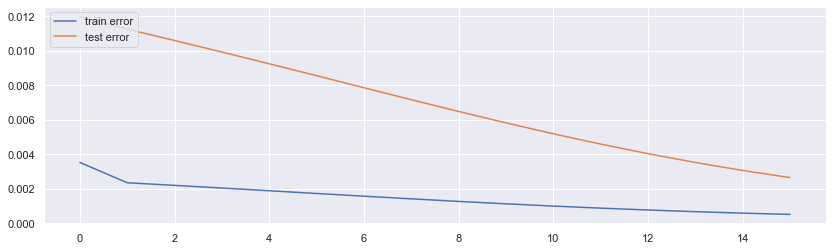


Epoch 16 Loss: 0.00045041135766704584
Performance on test range: 0.002282879315316677


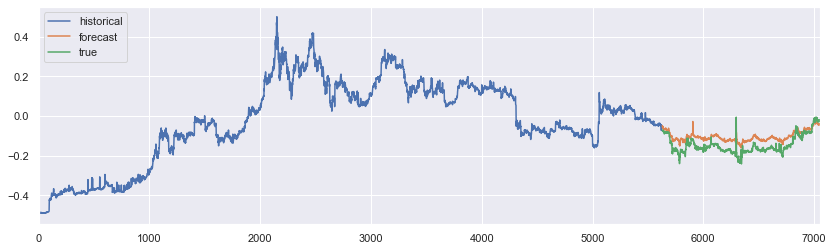

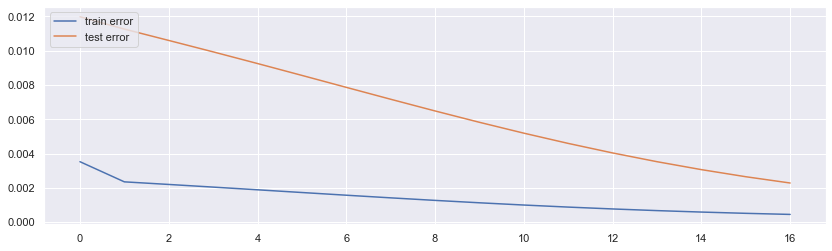


Epoch 17 Loss: 0.0003963940370632064
Performance on test range: 0.001961324829608202


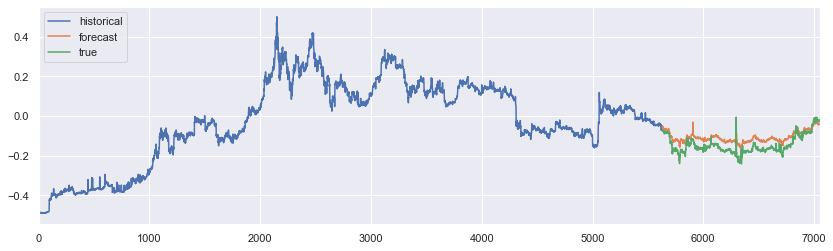

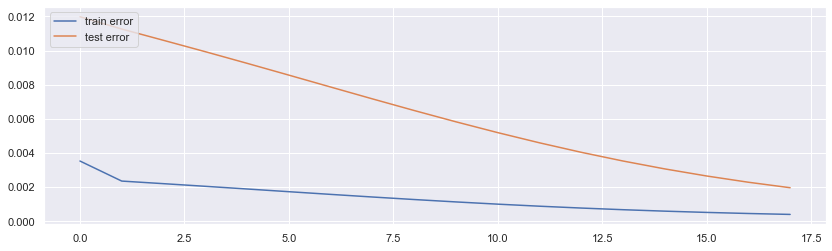


Epoch 18 Loss: 0.00035081352831141074
Performance on test range: 0.0016821336466819048


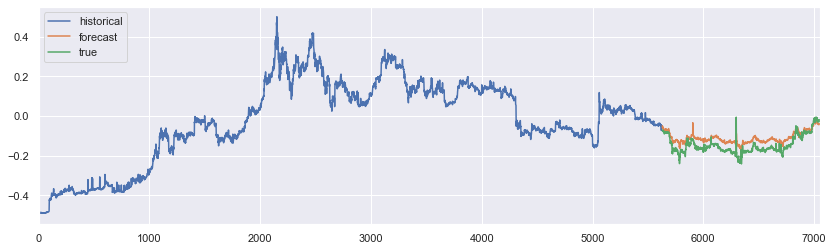

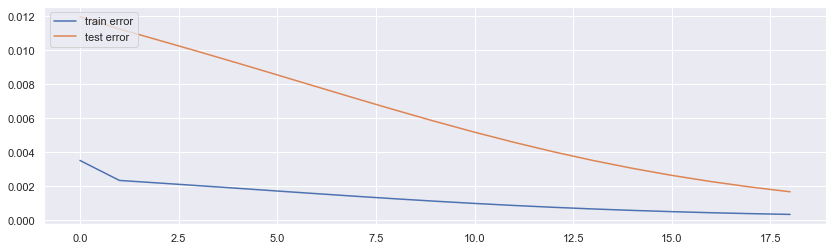


Epoch 19 Loss: 0.0003126312471455764
Performance on test range: 0.0014417064376175404


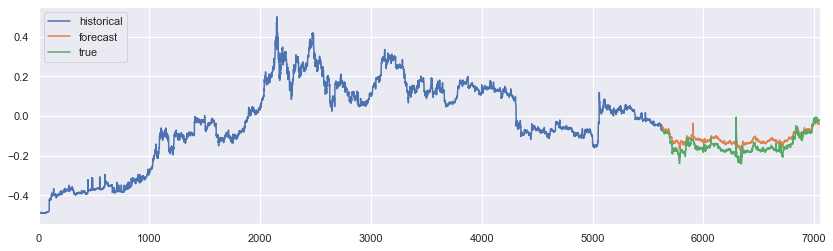

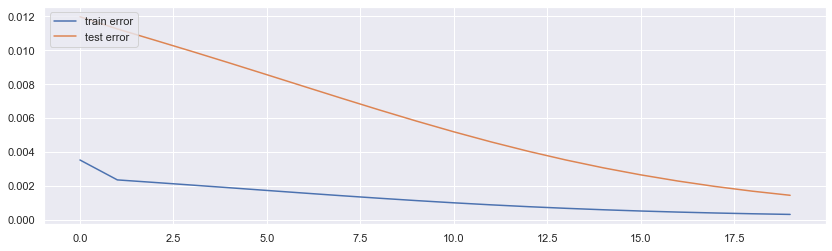


Epoch 20 Loss: 0.00028084093299714436
Performance on test range: 0.0012361591216176748


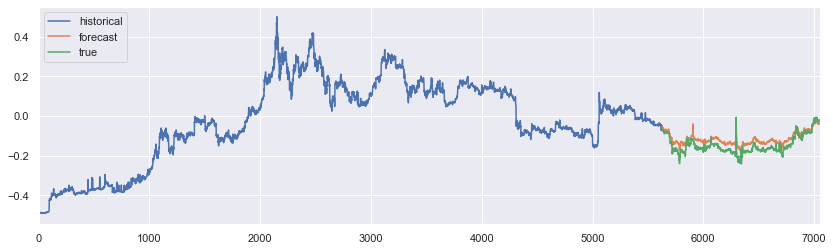

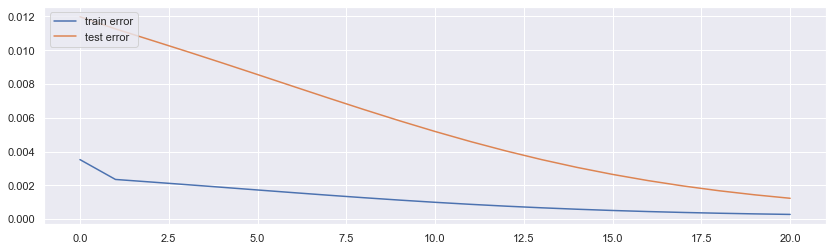


Epoch 21 Loss: 0.00025450391116950286
Performance on test range: 0.001061511691659689


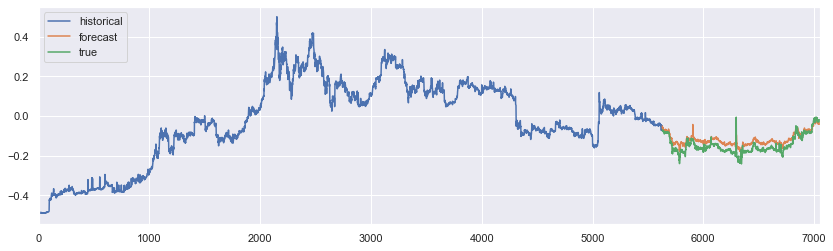

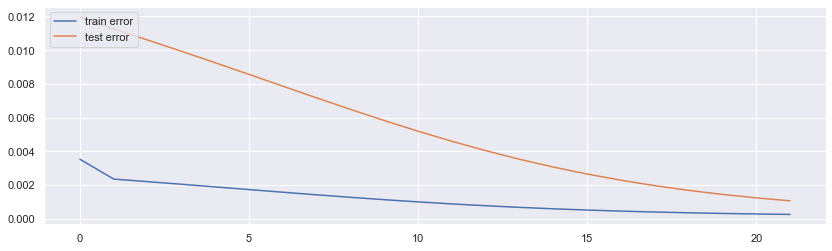


Epoch 22 Loss: 0.0002327700524178669
Performance on test range: 0.000913908937945962


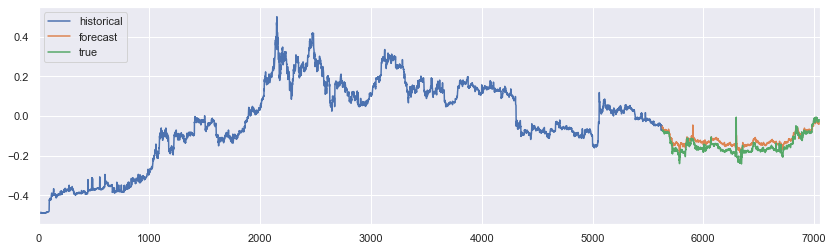

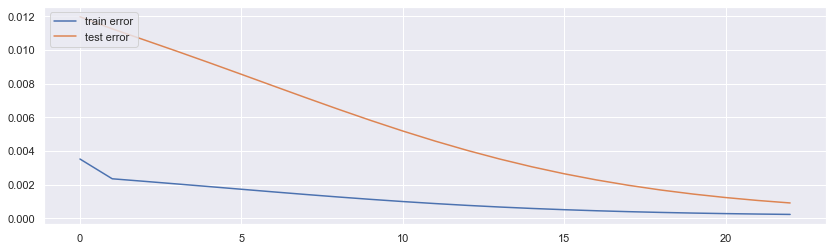

In [ ]:
epochs = 25
future = test_df.shape[0]
err_train =[]
err_test = []

for i in range(epochs):
    y_pred_res = []
    y_true_res = []
    total_loss = 0
    for seq, y_train in tqdm(train_data):
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size), 
                       torch.zeros(1,1,model.hidden_size)) # inicializacia
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    err_train.append(total_loss/len(train_data))
    print(f"Epoch {i} Loss: {total_loss/len(train_data)}")
    
    preds = train_df[-window_size:].values
    #print(preds.shape)
    for f in range(future):
        #print(preds.shape)
        seq = torch.cuda.FloatTensor(preds[-window_size:])
        
        with torch.no_grad():
            
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                           torch.zeros(1,1,model.hidden_size)) 

            y_pred = np.array(model(seq).item())
            
            y_pred_res.append(y_pred.item())
            y_true_res.append(test_df.iloc[f:f+1].loc[:, test_df.columns == 'target'].values.item())
            #import pdb; pdb.set_trace()
            new = test_df.iloc[f:f+1].loc[:,].values
            preds = np.insert(preds, preds.shape[0], new, axis=0)
            #import pdb; pdb.set_trace()
            #preds.append(model(seq).item())
    
    #import pdb; pdb.set_trace()
    loss = criterion(torch.Tensor(y_pred_res), torch.Tensor(y_true_res))
    err_test.append(loss)
    print(f"Performance on test range: {loss}")

    plt.figure(figsize = (14,4))
    plt.xlim(0, len(train_data)+future)
    #plt.ylim(6000, 10000)
    plt.grid(True)
    plt.plot(train_df.iloc[window_size:].target.values, label='historical')
    plt.plot(range(len(train_data), len(train_data)+future), y_pred_res, label='forecast')
    plt.plot(range(len(train_data), len(train_data)+future), y_true_res, label='true')
    plt.legend(loc="upper left")
    plt.show()
    
    plt.figure(figsize = (14,4))
    plt.grid(True)
    plt.plot(err_train, label='train error')
    plt.plot(err_test, label='test error')
    plt.legend(loc="upper left")
    plt.show()
    

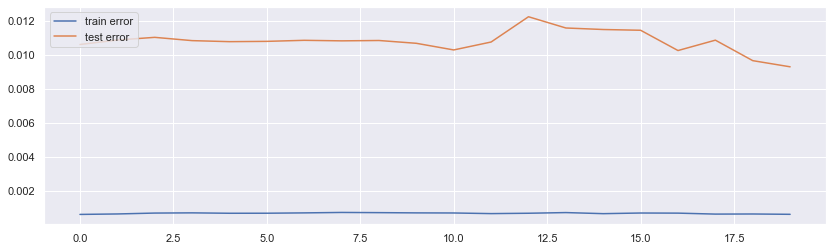

In [28]:
plt.figure(figsize = (14,4))
plt.grid(True)
plt.plot(err_train, label='train error')
plt.plot(err_test, label='test error')
plt.legend(loc="upper left")
plt.show()

In [ ]:
lstm = nn.LSTM(8, 2, batch_first=True)

In [ ]:
train_data[0][0].unsqueeze(0).shape

In [ ]:
train_data[0][0].float()

In [ ]:
torch.Tensor(train_data[0][0])

In [ ]:
lstm(train_data[0][0].float().unsqueeze(0))

In [ ]:
torch.zeros(1,1,50)